In [ ]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool


import numpy as np
import matplotlib.pyplot as plt

#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis')
#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis/computable-information-density')
#from joblib import Parallel, delayed

plt.style.use('sg_article')
#plt.rcParams.update({"figure.figsize": (9,6)})
#plt.rcParams.update({"text.usetex": True,})


from ComputableInformationDensity.cid import interlaced_time, cid2d
from ComputableInformationDensity.computable_information_density import cid

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [7]:
LL = 512
base_path = f'Z:\\cid\\na{LL}'
save_path = f'data\\nematic\\\\na{LL}'

act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]
act_list.sort()
act_list;

In [8]:
act_dir_list = [os.path.join(base_path, os.listdir(base_path)[i]) for i in range(len(os.listdir(base_path)))]
act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]

act_list[1] = 0.21
# sort act_list and act_dir_list by act_list
act_dir_list = [x for _, x in sorted(zip(act_list, act_dir_list))]

LL = 512
nexp=5
output_suffix='_nb5cg4'
output_suffix='_lz77_c4_nb5_o0_c4'
output_suffix='_nb5cg4'
# extract parameter dict for first run
exp_dirs = [x[0] for x in os.walk(act_dir_list[0])][1:]
with open(os.path.join(exp_dirs[0]  , f'cid_params{output_suffix}.pkl'), 'rb') as f:
        cid_params = pkl.load(f)

TODO:

CONSIDER: maybe exp_av should be taken AFTER all analyses of each series. otherwise
          we are obscuring patterns and interactings immediately´
... also: consider that it is not useful for eg the cid-grid.
--> think you a little about
- account for conv_list
- we need 3 avs for frac array
... do both weighted and no
... temp corr account for 

In [9]:
extract = False
cid_suff = cid_params['cid_mode']

nhilbert_views = 8
nshuffle = cid_params['nshuffle']
ncubes = cid_params['ncubes']
npartitions = cid_params['npartitions']


#exp_list = [i for i in range(nexp)]

base_path = f'Z:\\cid\\na{LL}'
outpath = f'data\\nematic\\na{LL}'
if not os.path.exists(outpath):
    os.makedirs(outpath)

act_dir_list = [os.path.join(base_path, os.listdir(base_path)[i]) for i in range(len(os.listdir(base_path)))]
act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]

act_list.sort()
act_dir_list = [x for _, x in sorted(zip(act_list, act_dir_list))]

cid_arr = np.nan * np.zeros((ncubes, npartitions, len(act_list), nexp, 2))
cid_shuffle_arr = np.nan * np.zeros((ncubes, npartitions, len(act_list), nexp, 2))
cid_frac_arr = np.nan * np.zeros((ncubes, npartitions, len(act_list), nexp, 2))

if extract:

    for i, act_dir in enumerate(act_dir_list):
        exp_dir_list =  [x[0] for x in os.walk(act_dir)][1:]
        #exp_dir_list = [x for _, x in sorted(zip(exp_list, exp_dir_list))]
        for j, exp_dir in enumerate(exp_dir_list):
            # load cid.pkl if it exists
            try:
                data_npz = np.load(os.path.join(exp_dir, f'cid{output_suffix}.npz'), allow_pickle=True)
            except:
                print(f'cid{output_suffix}.npz not found in {exp_dir}, skipping...')
                continue
           # with open(os.path.join(exp_dir, f'cid_{output_suffix}.pkl'), 'rb') as f:
            #    cid_dict = pkl.load(f)
            nframes = data_npz['cid'].shape[0]
            # extract cid values
            cid_arr[-nframes:, :, i, j, :] = data_npz['cid']
            cid_shuffle_arr[-nframes:, :, i, j, :] = data_npz['cid_shuffle']


    cid_frac_arr[:, :, :, :, 0] = cid_arr[:, :, :, :, 0] / cid_shuffle_arr[:, :, :, :, 0]
    cid_frac_arr[:, :, :, :, 1] = cid_frac_arr[:, :, :, :, 0] * np.sqrt( (cid_arr[:, :, :, :, 1]/cid_arr[:, :, :, :, 0])**2 + (cid_shuffle_arr[:, :, :, :, 1]/cid_shuffle_arr[:, :, :, :, 0])**2 )

    # save cid_arr, cid_shuffle_arr, cid_frac_arr
    np.savez_compressed(os.path.join(outpath, f'cid_data{output_suffix}.npz'), cid=cid_arr, cid_shuffle=cid_shuffle_arr, cid_frac=cid_frac_arr, act_list=act_list)
else:
    data_npz = np.load(os.path.join(outpath, f'cid_data{output_suffix}.npz'), allow_pickle=True)
    cid_arr = data_npz['cid']
    cid_shuffle_arr = data_npz['cid_shuffle']
    cid_frac_arr = data_npz['cid_frac']
    act_list = data_npz['act_list']


In [10]:
frac_exp_avw = np.nan * np.zeros((ncubes, npartitions, len(act_list), 2))
frac_savw = np.nan * np.zeros((ncubes, len(act_list), 2))
frac_tavw = np.nan * np.zeros((npartitions, len(act_list), 2))
frac_avw = np.nan * np.zeros((len(act_list), 2))

frac_exp_av = np.nan * np.zeros((ncubes, npartitions, len(act_list), 2))
frac_sav = np.nan * np.zeros((ncubes, len(act_list), 2))
frac_tav = np.nan * np.zeros((npartitions, len(act_list), 2))
frac_av = np.nan * np.zeros((len(act_list), 2))

frac_exp_av[:, :, :, 0] = np.nanmean(cid_frac_arr[:,:,:,:,0], axis=3)
frac_exp_av[:, :, :, 1] = np.nanstd(cid_frac_arr[:,:,:,:,0], axis=3) / np.sqrt(np.sum(~np.isnan(cid_frac_arr[:,:,:,:,0]), axis=3))
frac_sav[:, :, 0] = np.nanmean(cid_frac_arr[:,:,:,:,0], axis=(1,3))
frac_sav[:, :, 1] = np.nanstd(cid_frac_arr[:,:,:,:,0], axis=(1,3)) / np.sqrt(np.sum(~np.isnan(cid_frac_arr[:,:,:,:,0]), axis=(1,3)))
frac_tav[:, :, 0] = np.nanmean(cid_frac_arr[:,:,:,:,0], axis=(0,3))
frac_tav[:, :, 1] = np.nanstd(cid_frac_arr[:,:,:,:,0], axis=(0,3)) / np.sqrt(np.sum(~np.isnan(cid_frac_arr[:,:,:,:,0]), axis=(0,3)))
frac_av[:, 0] = np.nanmean(cid_frac_arr[:,:,:,:,0], axis=(0,1,3))
frac_av[:, 1] = np.nanstd(cid_frac_arr[:,:,:,:,0], axis=(0,1,3)) / np.sqrt(np.sum(~np.isnan(cid_frac_arr[:,:,:,:,0]), axis=(0,1,3)))

frac_exp_avw[:, :, :, 0], frac_exp_avw[:, :, :, 1] = calc_weighted_mean(cid_frac_arr[:, :, :, :, 0] , cid_frac_arr[:, :, :, :, 1], axis=-1, omit_null_uncertainties=True)
frac_savw[:, :, 0], frac_savw[:, :, 1] = calc_weighted_mean(frac_exp_av[:, :, :, 0], frac_exp_av[:, :, :, 1], axis=1, omit_null_uncertainties=True)
frac_tavw[:, :, 0], frac_tavw[:, :, 1] = calc_weighted_mean(frac_exp_av[:, :, :, 0], frac_exp_av[:, :, :, 1], axis=0, omit_null_uncertainties=True)
frac_avw[:, 0], frac_avw[:, 1] = calc_weighted_mean(frac_exp_av[:, :, :, 0], frac_exp_av[:, :, :, 1], axis=(0,1), omit_null_uncertainties=True)
#frac_avw[:, 0], frac_avw[:, 1] = calc_weighted_mean(cid_frac_arr[:,:,:,:,0], cid_frac_arr[:,:,:,:,1], axis=(0,1,3), omit_null_uncertainties=True)
#frac_exp_av[:, :, :, 0] = frac_exp_avw[0]
#frac_exp_av[:, :, :, 1] = frac_exp_avw[1]
np.isnan(frac_exp_avw[-5:, :, :, 0]).sum() / frac_exp_avw[-5:, :, :, 0].size
np.isnan(frac_savw[-5:, :, 0]).sum() / frac_savw[-5:, :, 0].size

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_7808\3691071056.py:11: RuntimeWarning: Mean of empty slice
  frac_exp_av[:, :, :, 0] = np.nanmean(cid_frac_arr[:,:,:,:,0], axis=3)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_7808\3691071056.py:13: RuntimeWarning: Mean of empty slice
  frac_sav[:, :, 0] = np.nanmean(cid_frac_arr[:,:,:,:,0], axis=(1,3))


0.0

(0.015, 0.035)

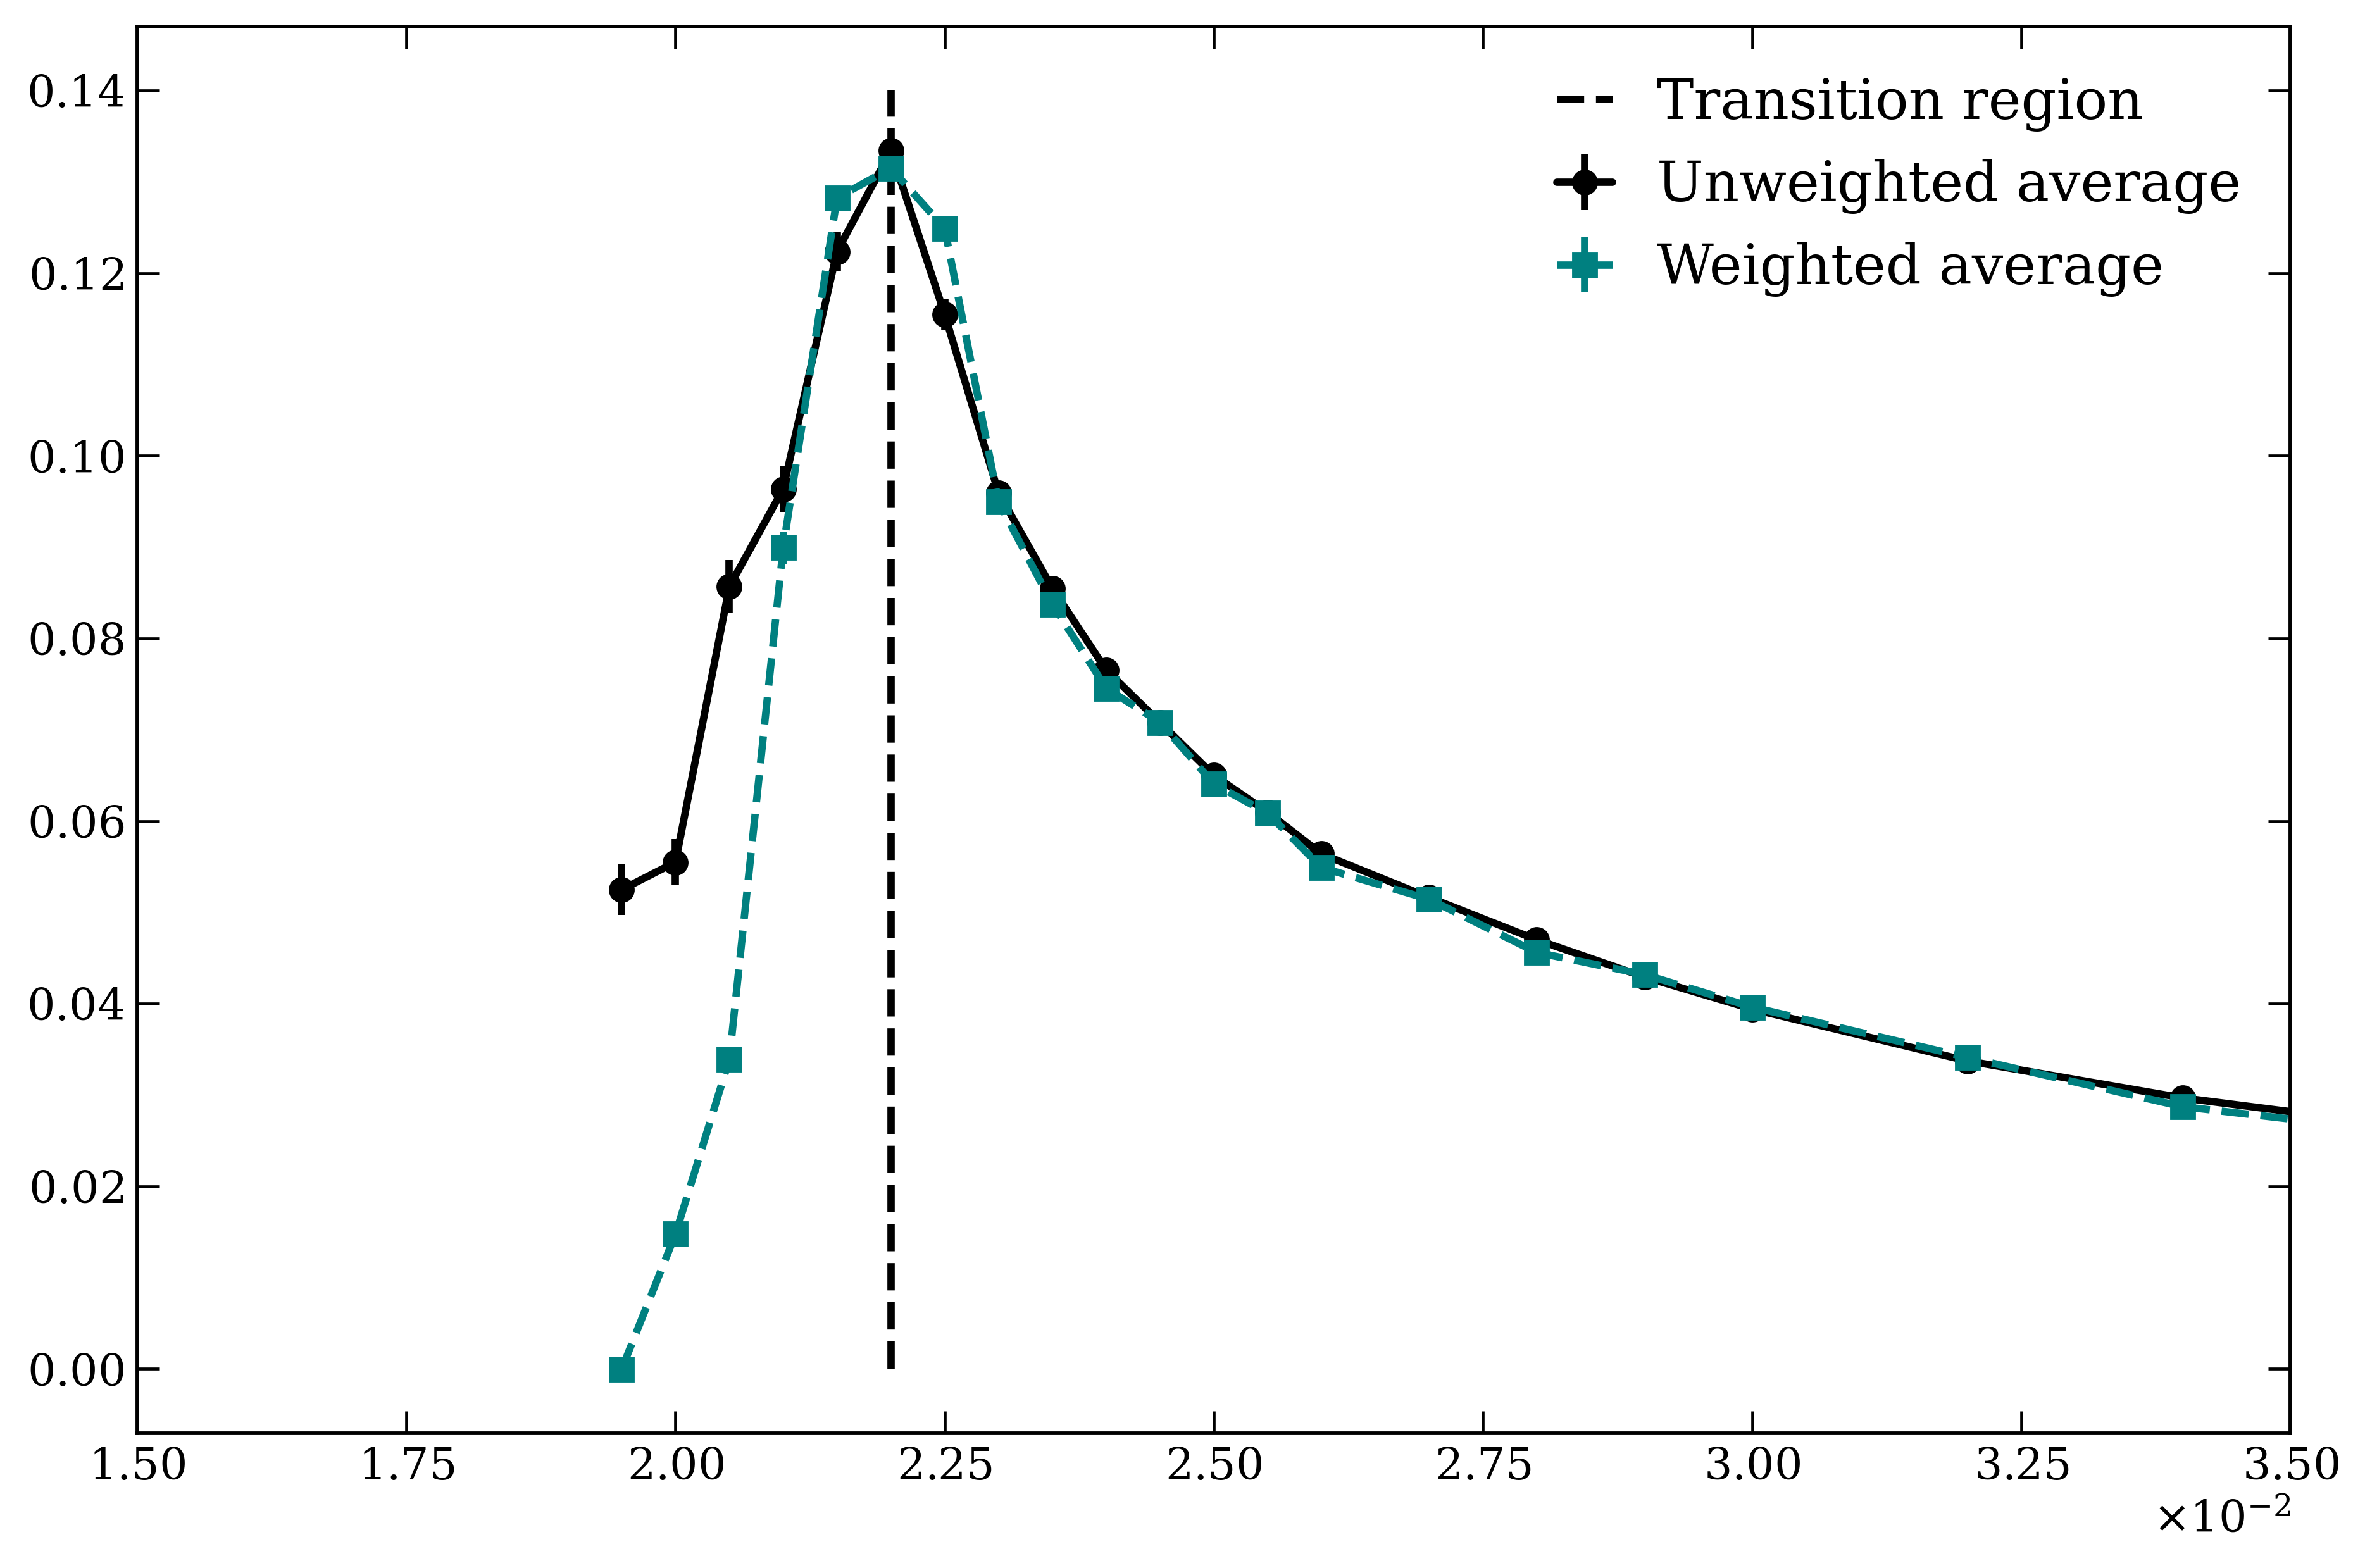

In [13]:
plt.errorbar(act_list, 1-frac_av[:, 0], yerr=frac_av[:, 1], fmt='o-', label='Unweighted average', color='k')
plt.errorbar(act_list, 1-frac_avw[:, 0], yerr=frac_avw[:, 1], fmt='s--', label='Weighted average', color='C0')
plt.vlines(0.022, 0,.14,color='k', linestyle='--', label='Transition region')
plt.legend()
plt.xlim(0.015,0.035)

(0.018, 0.035)

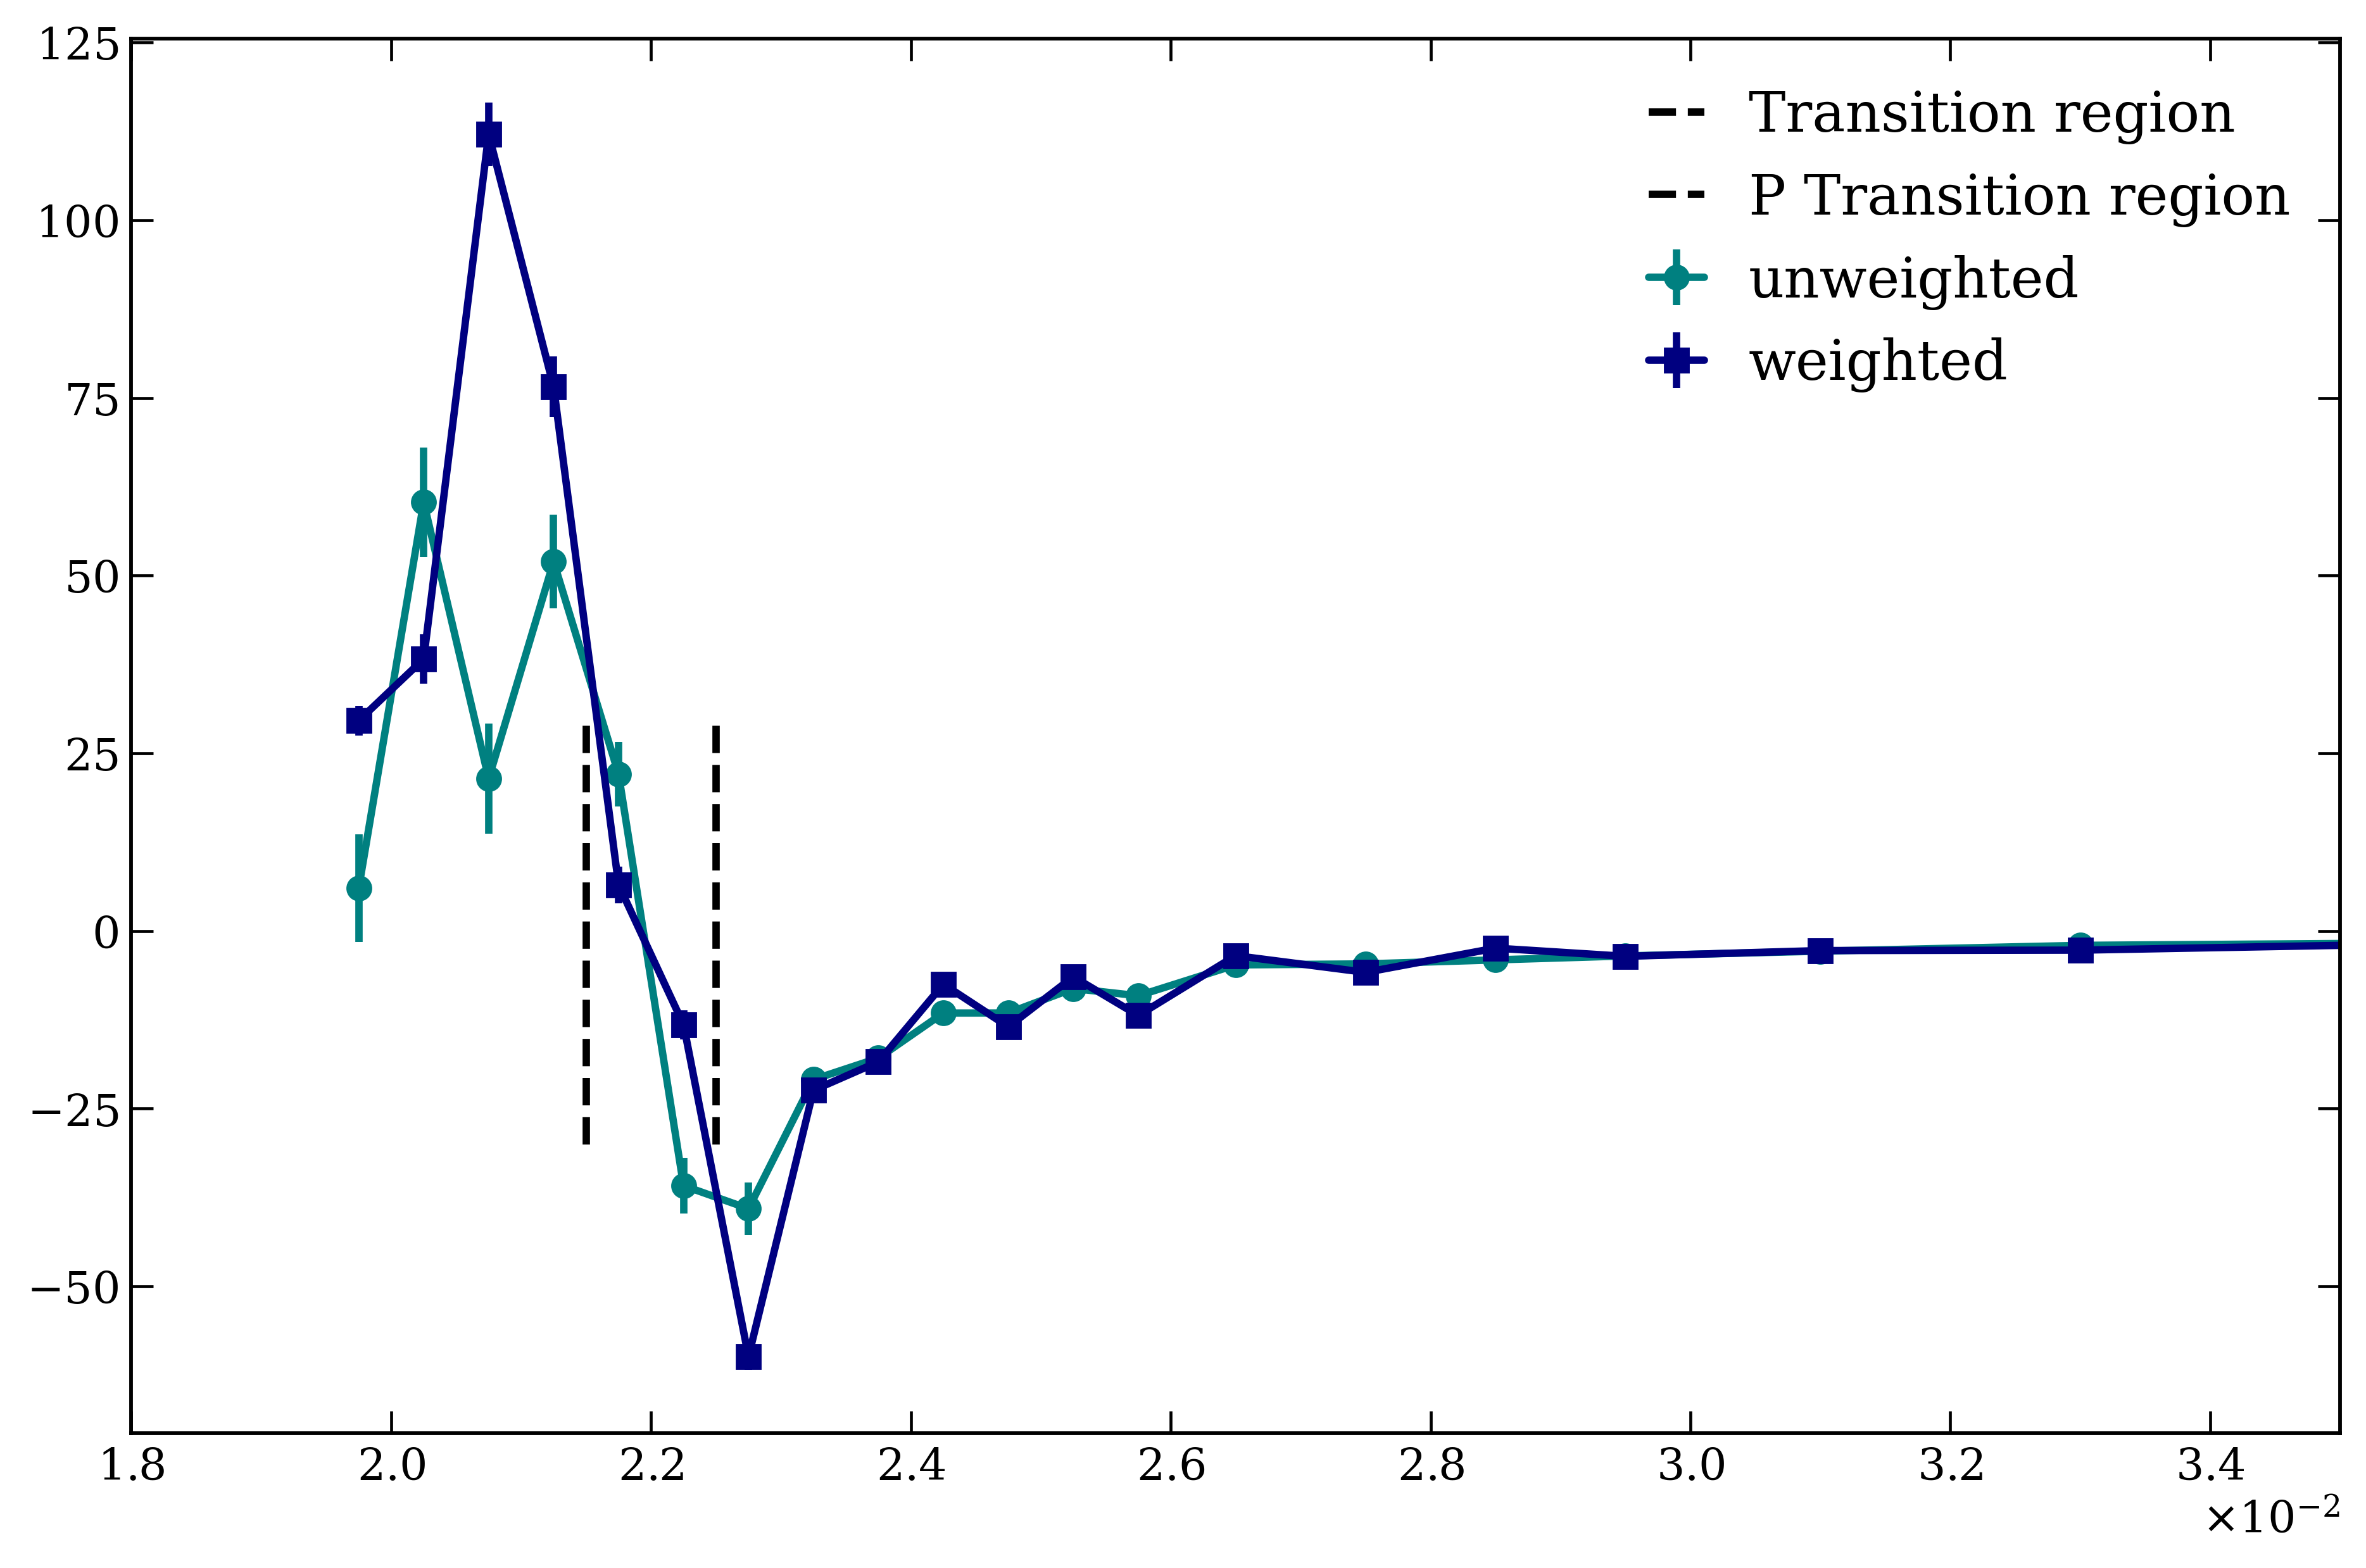

In [14]:

cid_diff = np.diff(frac_av[:, 0]) #/ ada.LX[N]**2


#act_shift = (np.array(act_list) - act_max) / act_max
act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
act_diff_tot = np.array(act_list[:-1]) + act_diff 

deriv_cid = cid_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
deriv_cid_err = np.sqrt(frac_av[:, 1][1:]**2 + frac_av[:,1][:-1]**2) / act_diff

deriv_cidw = np.diff(frac_avw[:, 0])/ act_diff 
deriv_cidw_err = np.sqrt(frac_avw[:, 1][1:]**2 + frac_avw[:,1][:-1]**2) / act_diff


plt.errorbar(np.array(act_list[:-1]) + act_diff/2 , -deriv_cid, yerr=deriv_cid_err,label='unweighted',marker='o')#, label = label)
plt.errorbar(np.array(act_list[:-1]) + act_diff/2 , -deriv_cidw, yerr=deriv_cidw_err,label='weighted',marker='s')#, label = label)
plt.vlines(0.0215, -30,30,color='k', linestyle='--', label='Transition region')
plt.vlines(0.0225, -30,30,color='k', linestyle='--', label='P Transition region')
plt.legend()
plt.xlim(0.018,0.035)

In [ ]:
plt.imshow(frac_tav[:,3,0].reshape(4,4), #vmin=0.8,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,4,0,4]   
        )

array([0.0195, 0.02  , 0.0205, 0.021 , 0.0215, 0.022 , 0.0225, 0.023 ,
       0.0235, 0.024 , 0.0245, 0.025 , 0.0255, 0.026 , 0.027 , 0.028 ,
       0.029 , 0.03  , 0.032 , 0.034 , 0.04  , 0.05  , 0.06  , 0.07  ,
       0.08  , 0.09  , 0.1   , 0.15  , 0.2   ])

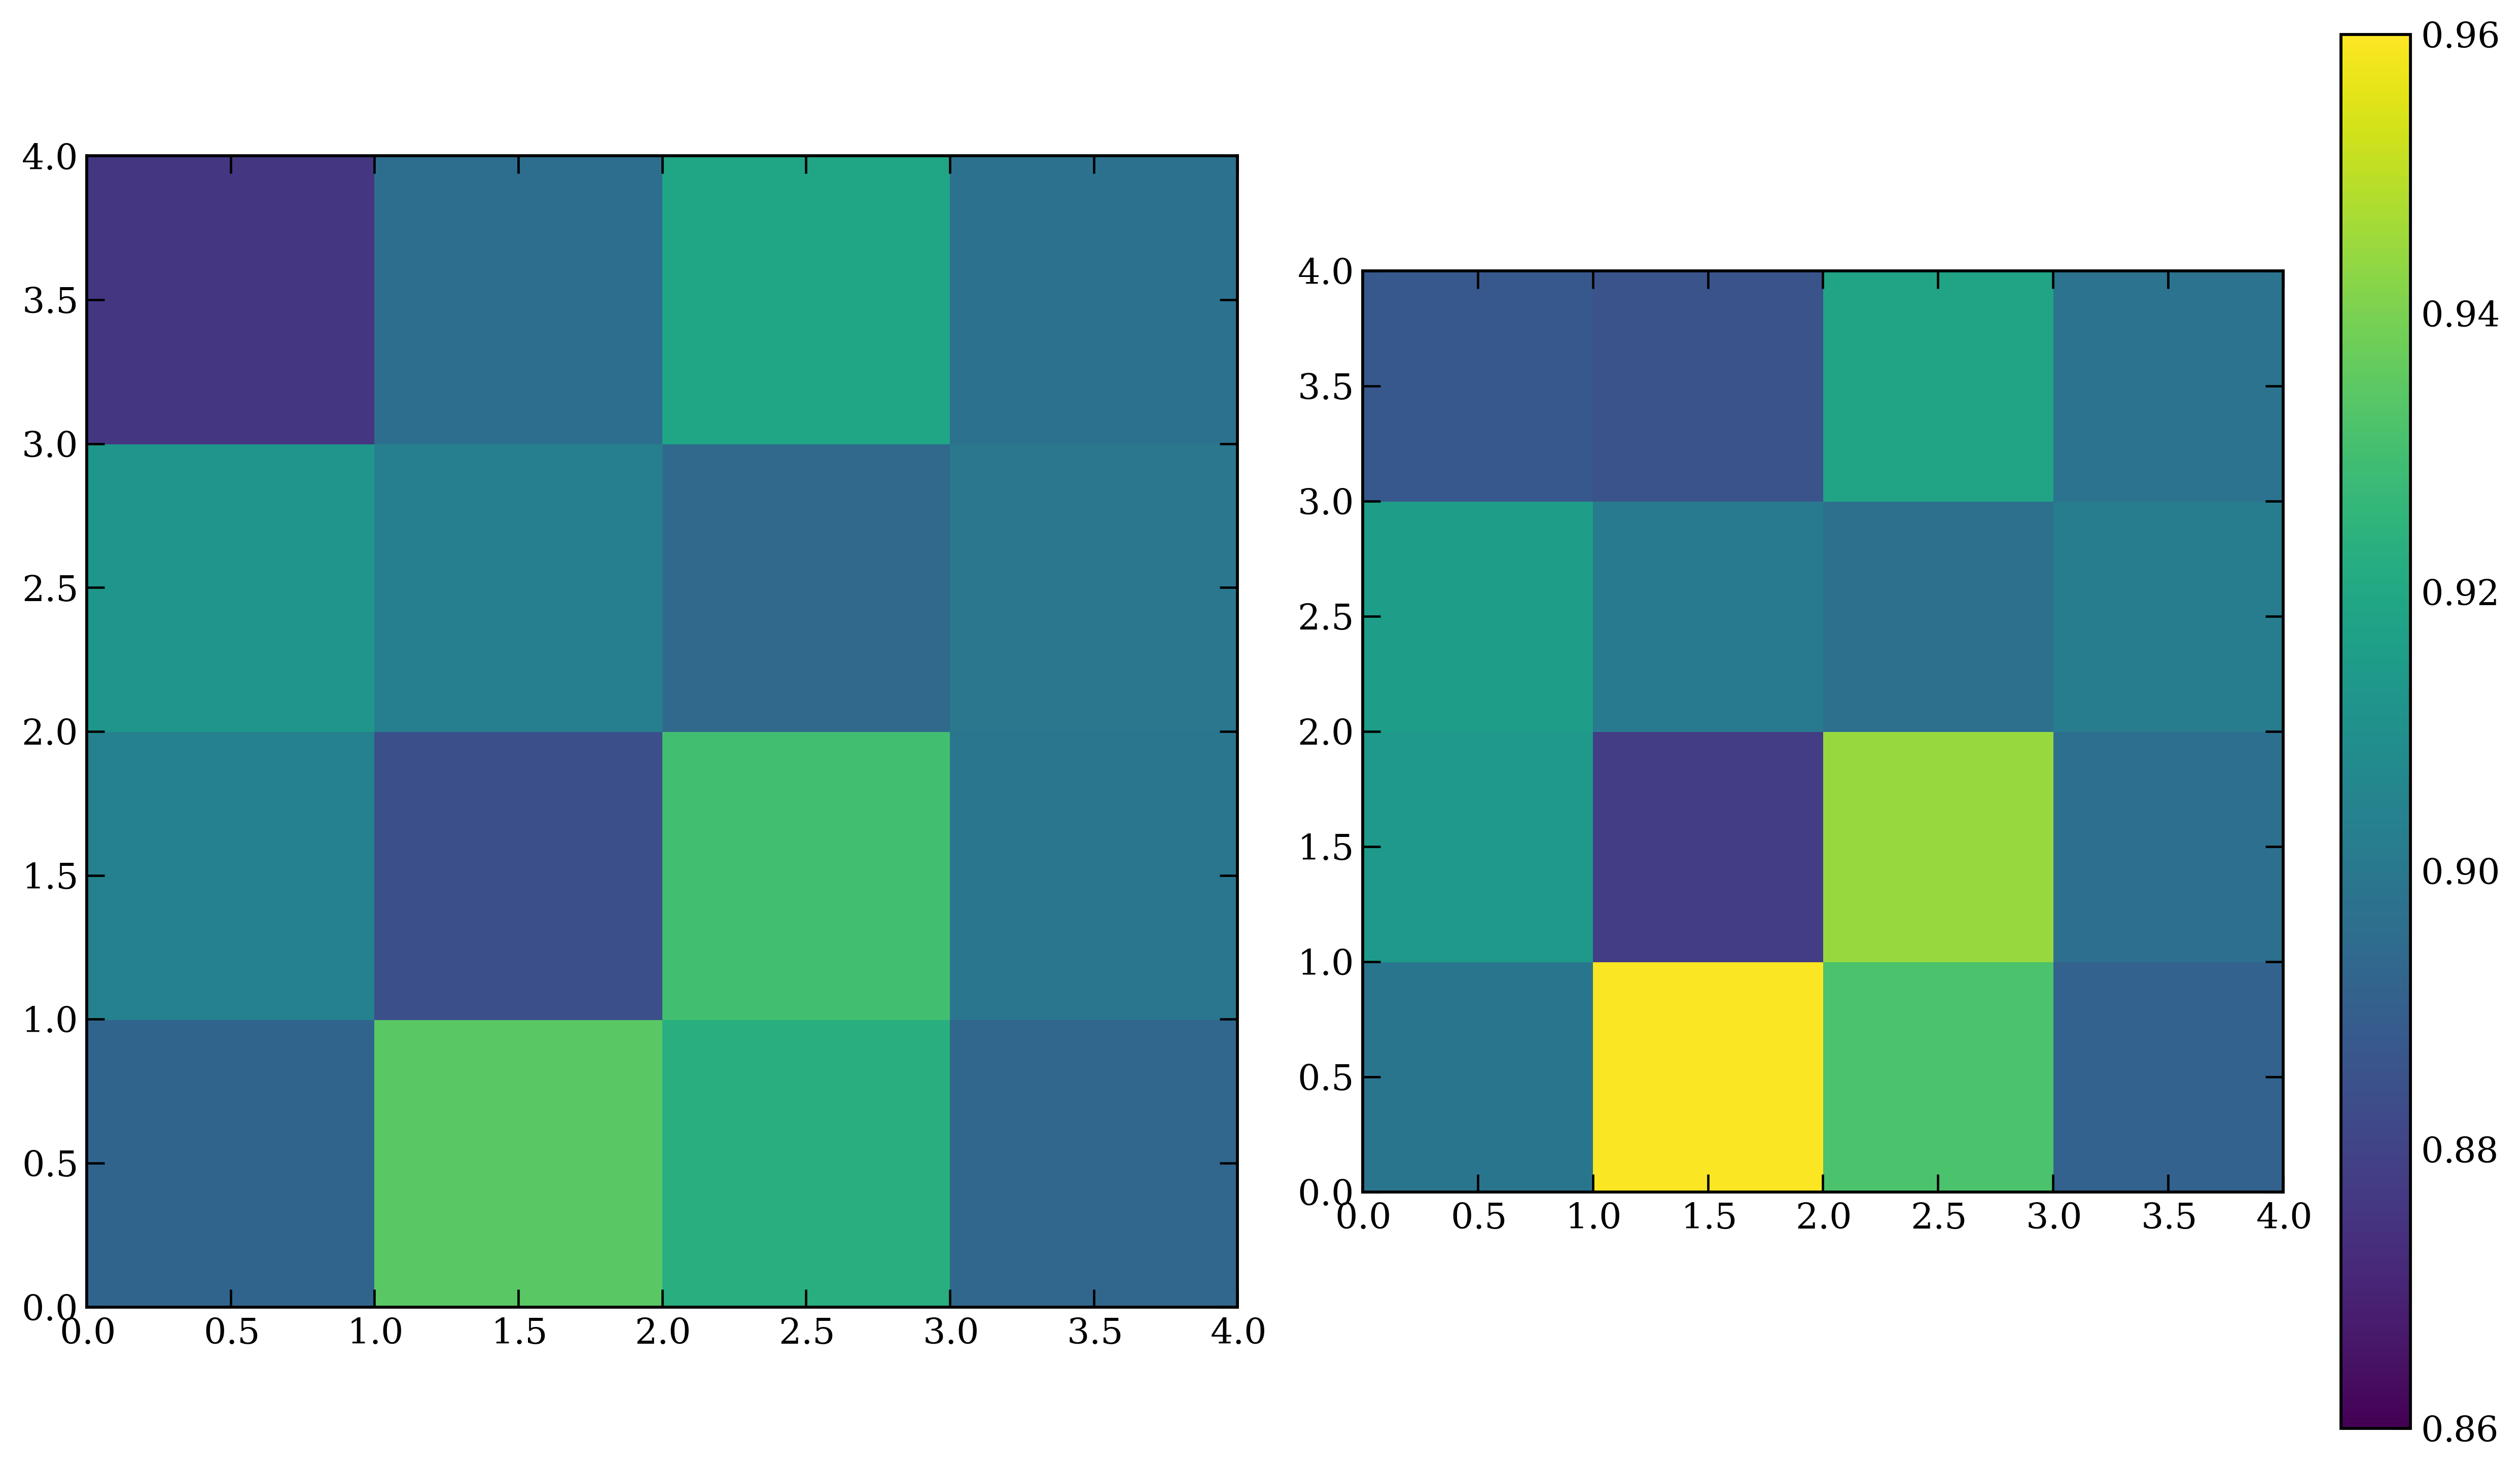

In [41]:
fig, ax = plt.subplots(ncols=2,figsize=(12,7))
ax[0].imshow(frac_tav[:,3,0].reshape(4,4), vmin=0.86, vmax=0.96,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,4,0,4]   
        )
ax[1].imshow(frac_tavw[:,3,0].reshape(4,4), vmin=0.86, vmax=0.96,#vmin=0.8,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,4,0,4]  ) 
#fig.colorbar(ax[0].images[0], ax=ax[0], label='CID / CID shuffle')
fig.colorbar(ax[1].images[0], ax=ax[1],)# label='CID / CID shuffle')

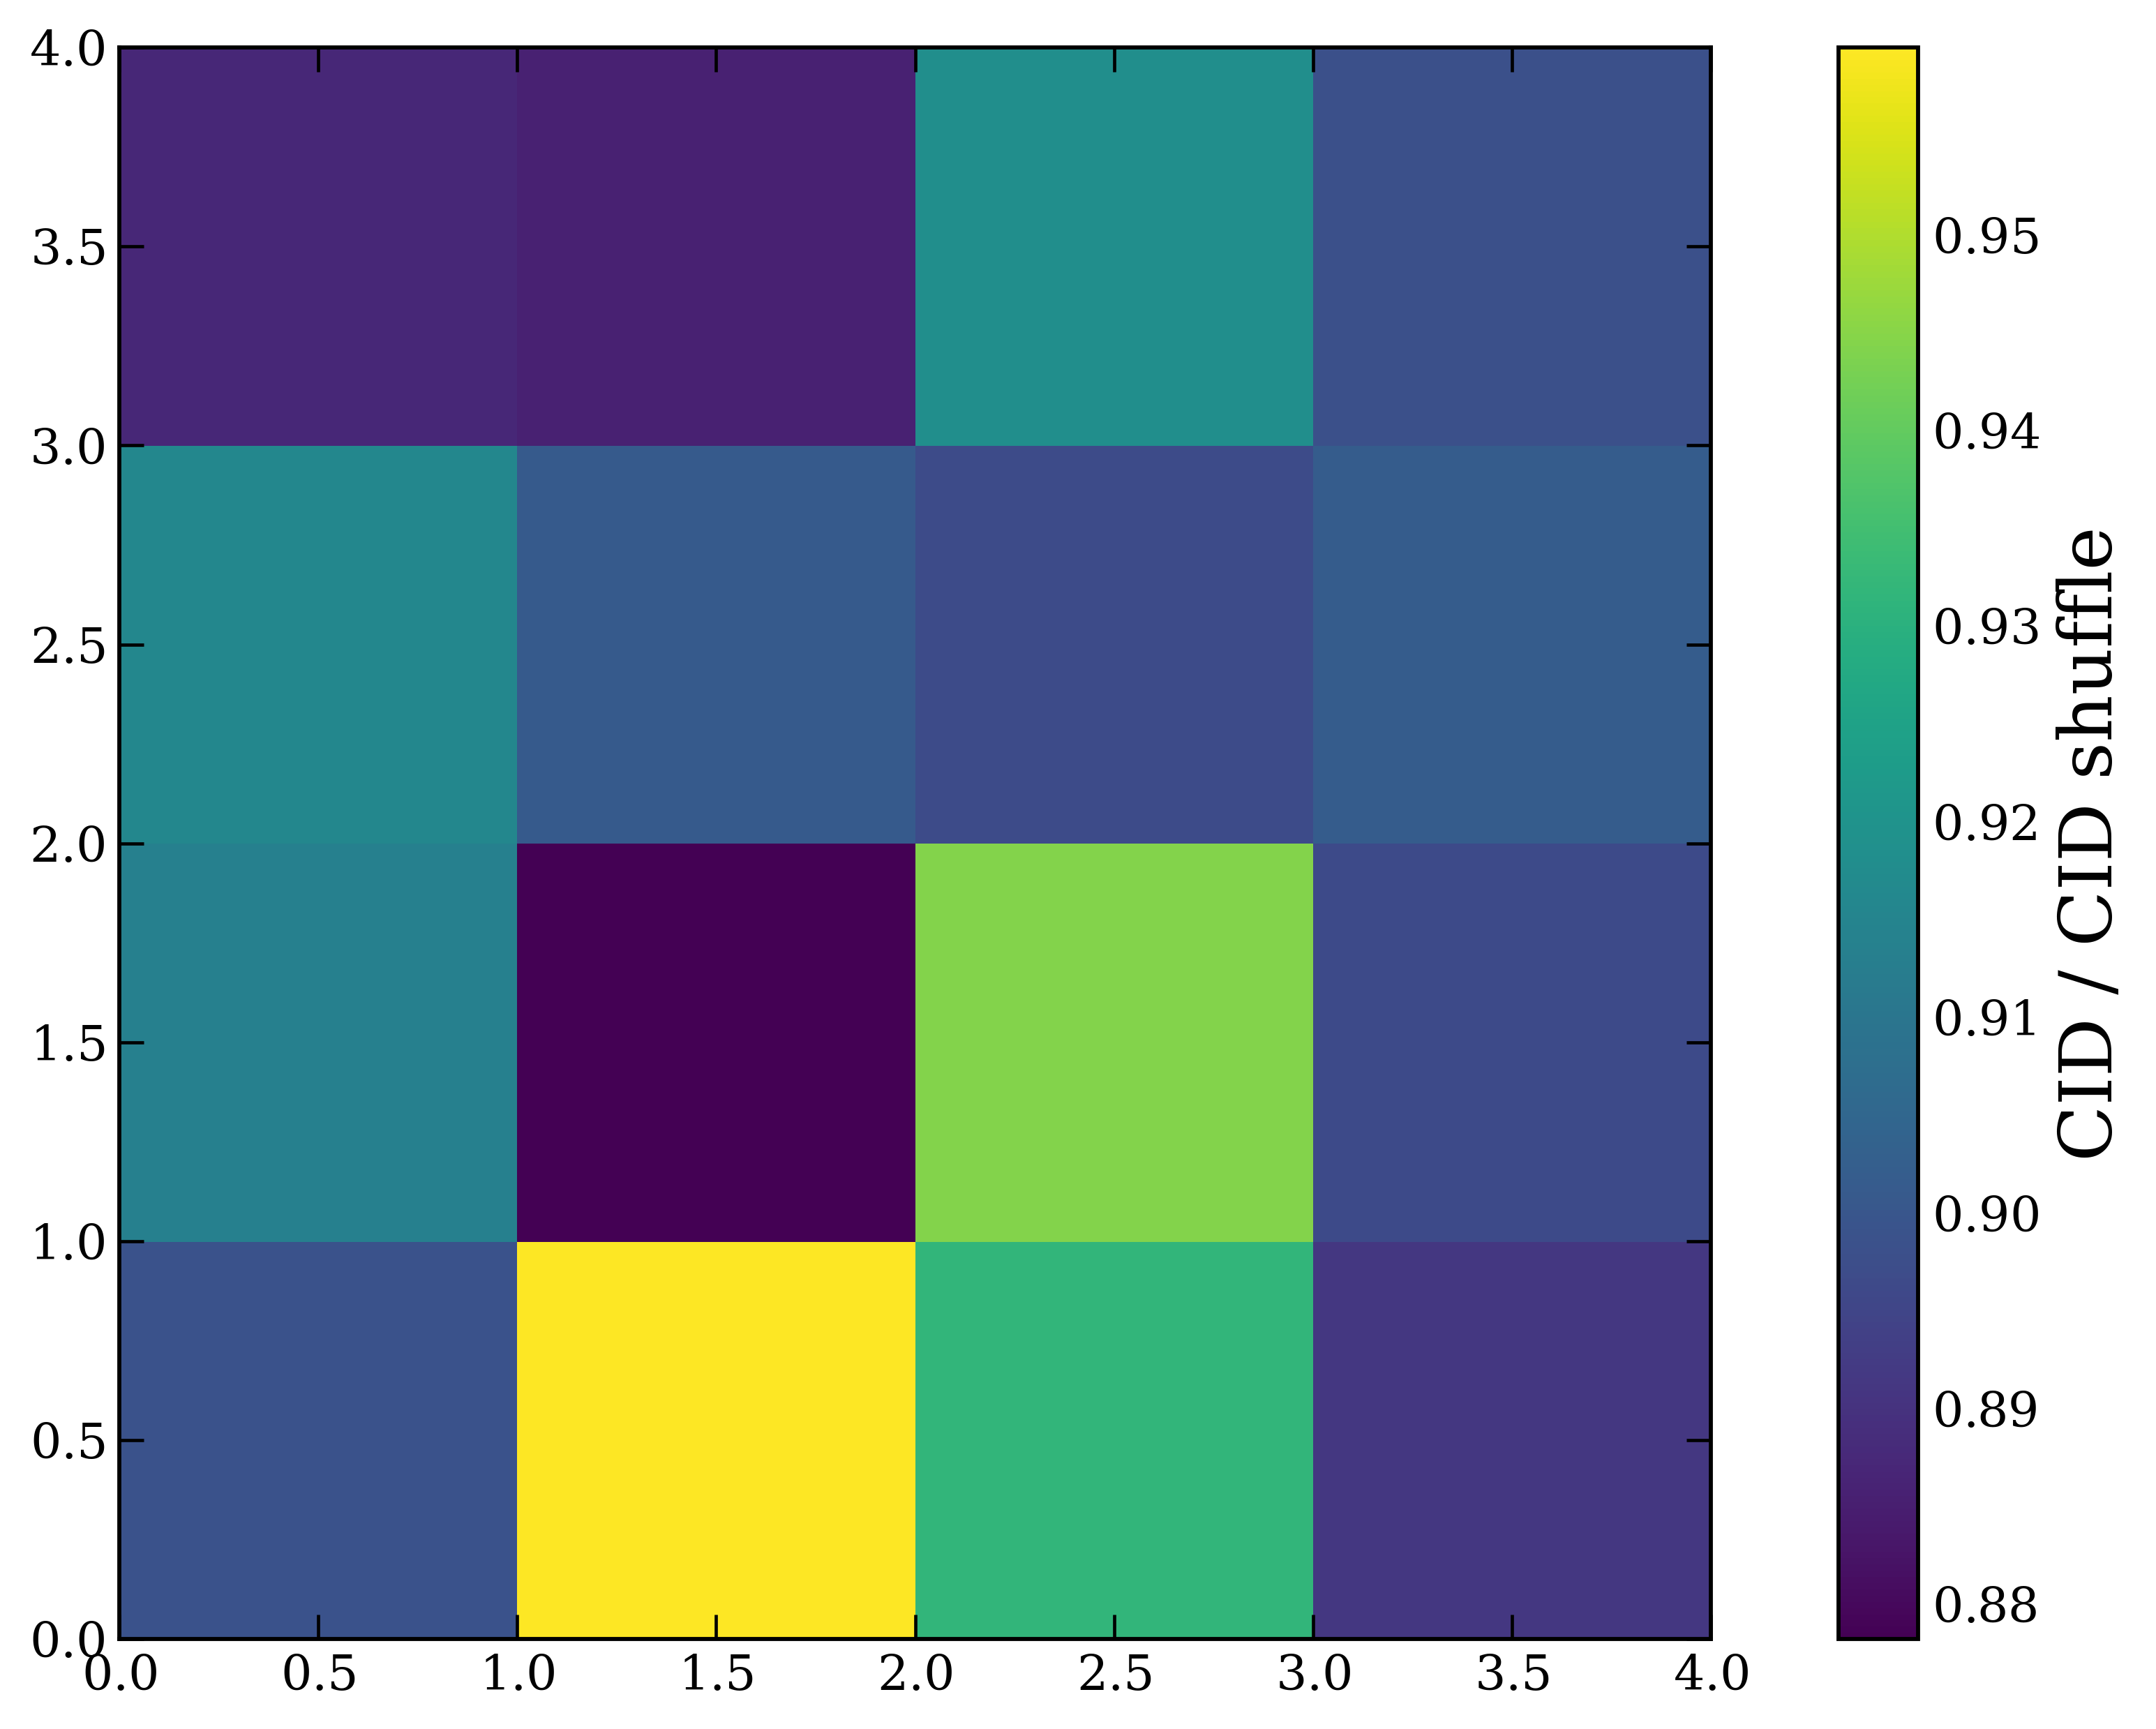

In [28]:
plt.imshow(frac_tavw[:,3,0].reshape(4,4), #vmin=0.8,# vmax=1.05
            cmap='viridis', origin='lower', extent=[0,4,0,4]   
        )
plt.colorbar(label='CID / CID shuffle')


In [42]:
frac_sav.shape

(12, 29, 2)

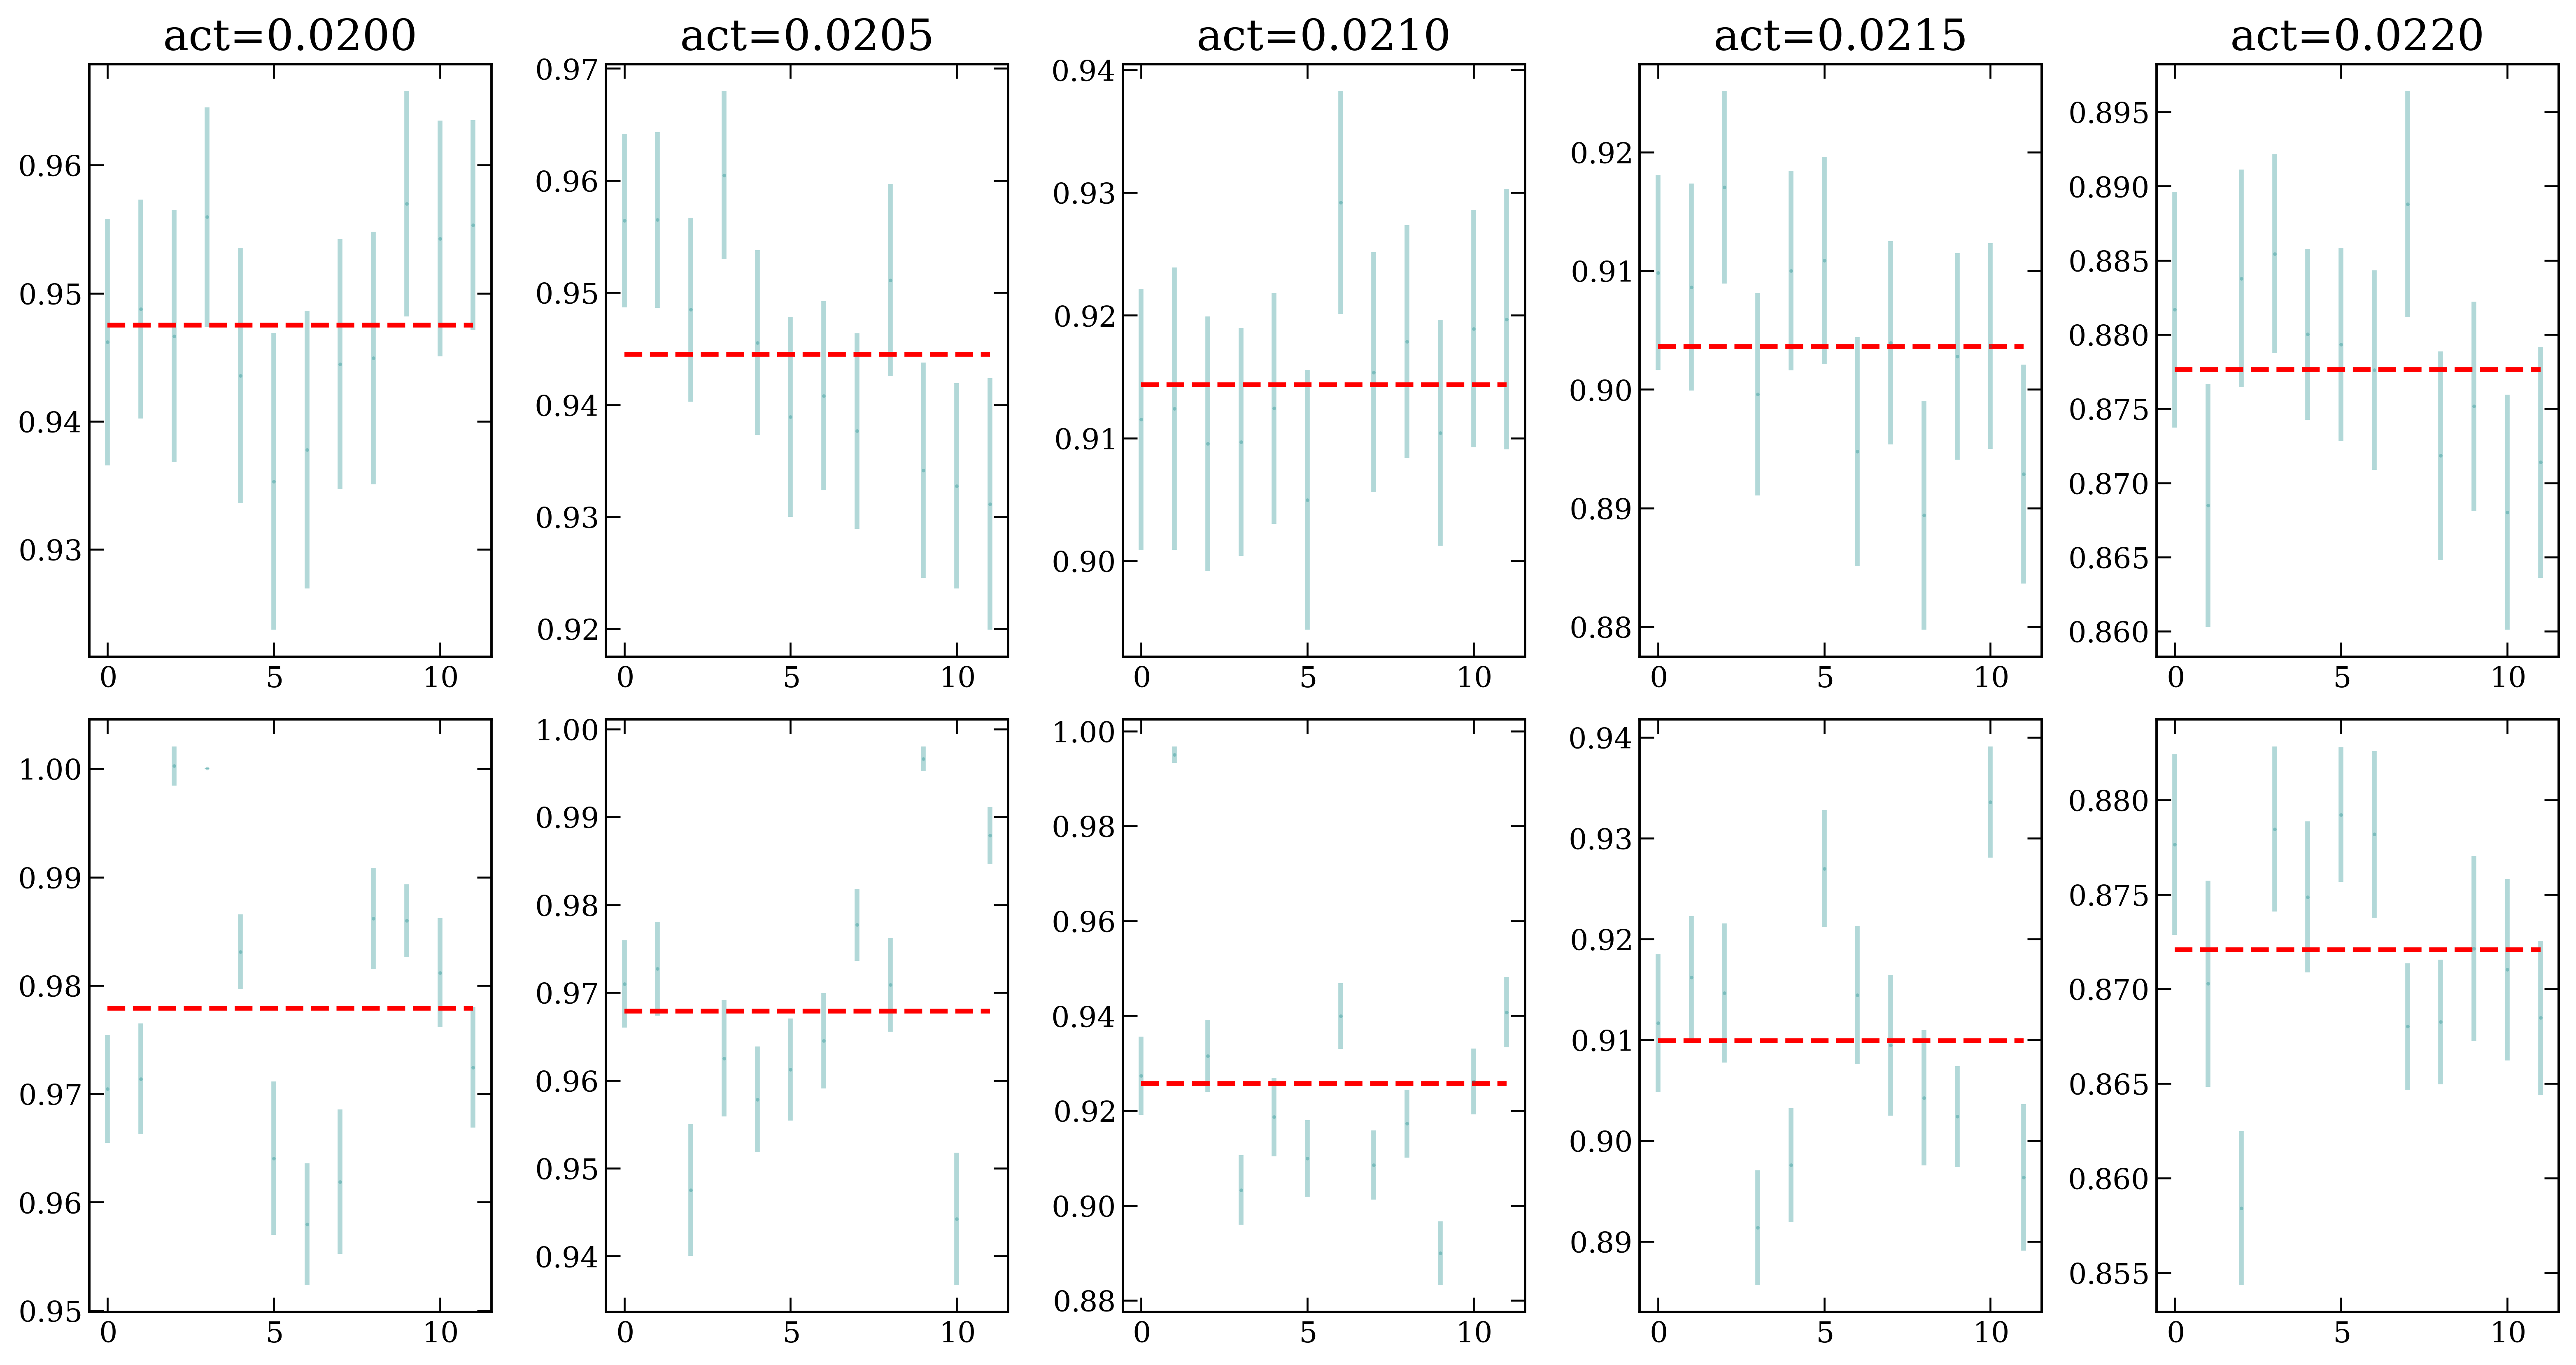

In [51]:
# plot mean and std of cid_arr, cid_shuffle_arr, cid_frac_arr over nexp for each act
ncols=5
actidx_min=1
fig, ax = plt.subplots(nrows=2,ncols=ncols,figsize=(15,8))
for i, act in enumerate(act_list[actidx_min:actidx_min+ncols]):

    ax[0,i].errorbar(np.arange(ncubes), frac_sav[:,i,0], yerr=frac_sav[:,i,1], fmt='.', label=f'act={act}',alpha=.3,ms=1)
    ax[0,i].hlines(np.nanmean(frac_sav[:,i,0]), 0, ncubes-1, colors='r', linestyles='--', label='mean last 10')
    ax[0,i].set_title(f'act={act:.4f}')
    ax[1,i].errorbar(np.arange(ncubes), frac_savw[:,i,0], yerr=frac_savw[:,i,1], fmt='.', label=f'act={act}',alpha=.3,ms=1)
    ax[1,i].hlines(np.nanmean(frac_savw[:,i,0]), 0, ncubes-1, colors='r', linestyles='--', label='mean last 10')
   #ax[1,i].set_title(f'act={act:.4f}')
                                                                   

In [ ]:
act_expanded = np.repeat(np.array(act_list)[None,:], npartitions, axis=0)
act_expanded = np.repeat(act_expanded[None,:,:], ncubes, axis=0)
act_expanded = np.repeat(act_expanded[:,:,:,None], nexp, axis=2)
plt.scatter(act_expanded, cid_frac_arr[:,:,:,:,0], marker='.', alpha=0.1)
plt.ylim(.6,1.1)
plt.xscale('log')

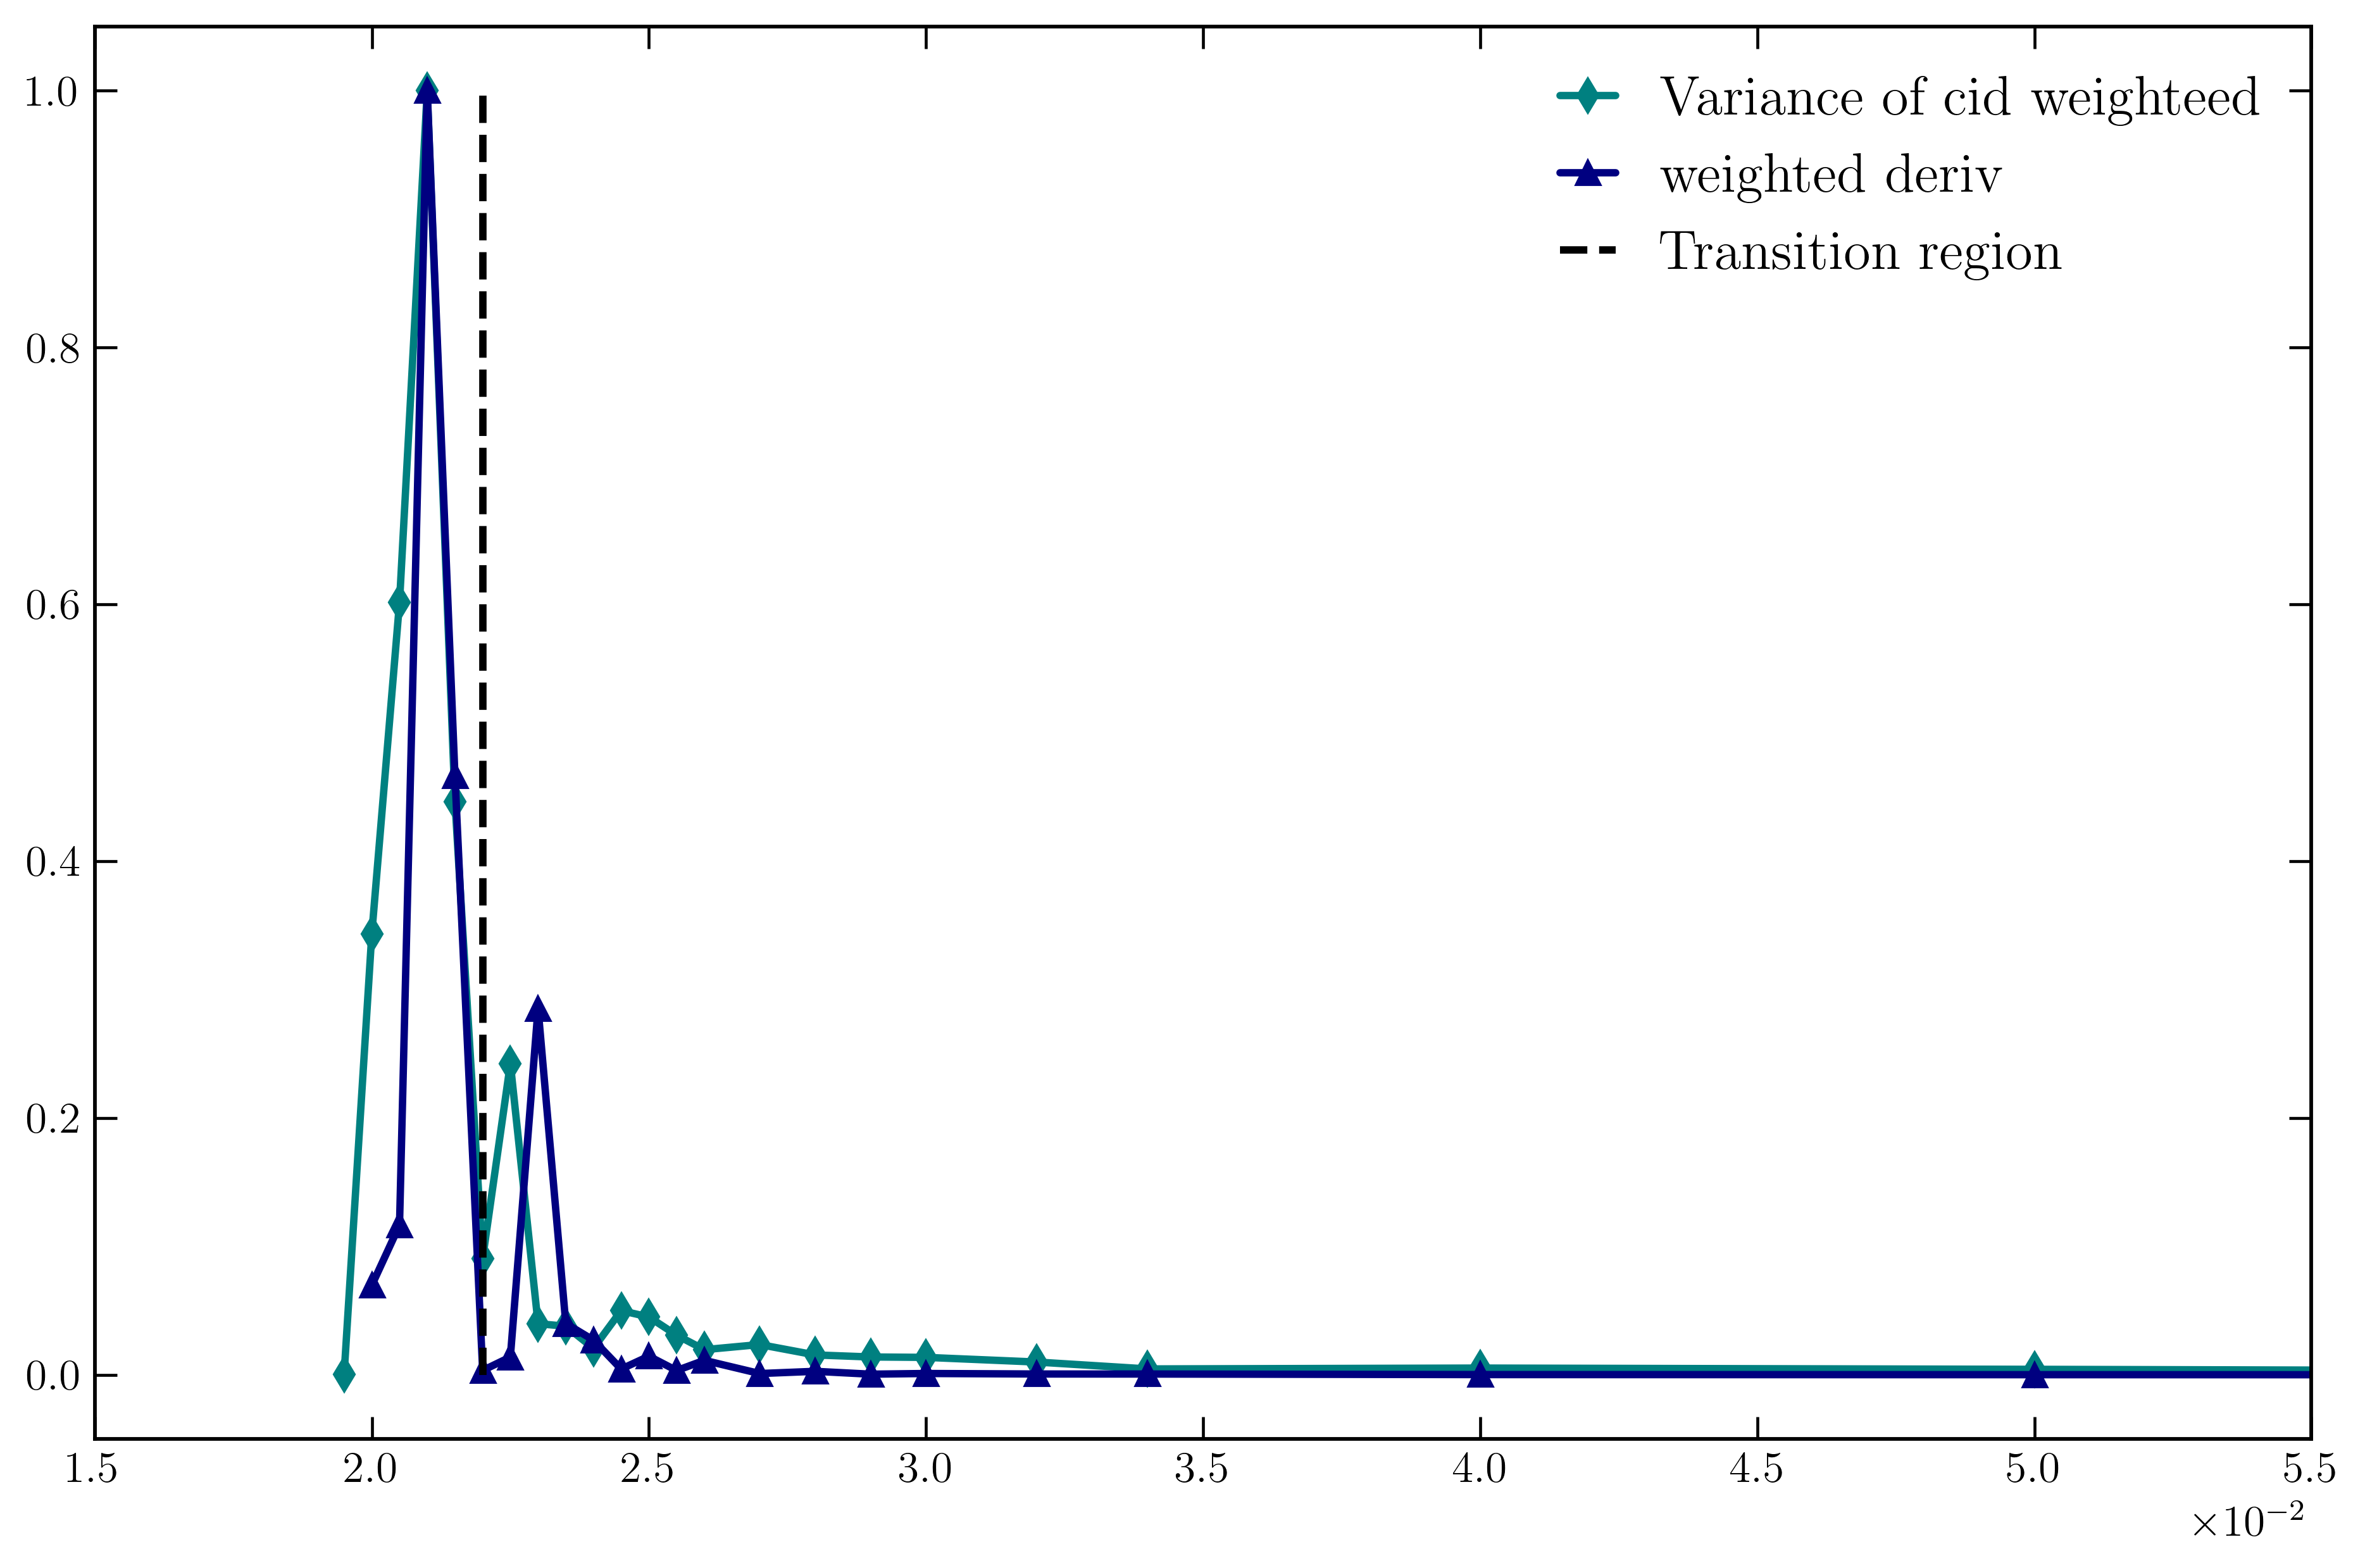

In [126]:
#plt.scatter(act_list, 1-np.mean(cid_frac_arr[:,:,0], axis=1))
plt.figure()
simp_var = np.nanvar(cid_frac_arr[:,:,:,:,0], axis=(0,1,3))
simp_var /= np.nanmax(simp_var)
#plt.plot(act_list, simp_var, label='Variance of simple mean', marker='o')
#plt.plot(act_list[:-1] + act_diff, deriv_cid_err[:]**2 / np.nanmax(deriv_cid_err[:]**2), marker='x', label='Variance of derivative')
#plt.plot(act_list[:-1] + act_diff, deriv_cidw_err[:]**2 / np.nanmax(deriv_cidw_err[:]**2), marker='s', label='Variance of weighted mean')
plt.plot(act_list[:], frac_avw[:,1]**2 / np.nanmax(frac_avw[:,1]**2), marker='d', label='Variance of cid weighteed')
plt.plot(act_list[:-1] + act_diff, deriv_cidw[:]**2 / np.nanmax(deriv_cidw[:]**2), marker='^', label='weighted deriv')
#plt.plot(act_list[:], frac_av[:,1]**2 / np.nanmax(frac_av[:,1]**2), marker='*', label='Variance of cid unweighteed')
#plt.plot(act_list[:-1] + act_diff, deriv_cid[:]**2 / np.nanmax(deriv_cid[:]**2), marker='v', label='unweighted deriv')
plt.xlim(0.015,0.055)
plt.vlines(0.022,0,1,color='k', linestyle='--', label='Transition region')
plt.legend()

In [ ]:
plot_divergence=True
nhilbert_views = 8
nshuffle = 8

cid_mean = np.mean(cid_arr[:,:,0], axis=1) 
cid_std = (np.std(cid_arr[:,:,0], axis=1) + np.mean(cid_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_mean_weighted, cid_std_weighted = calc_weighted_mean(cid_arr[:,:,0], cid_arr[:,:,1], omit_null_uncertainties=True)
cid_shuffle_mean_weighted, cid_shuffle_std_weighted = calc_weighted_mean(cid_shuffle_arr[:,:,0], cid_shuffle_arr[:,:,1], omit_null_uncertainties=True)

cid_shuffle_mean = np.mean(cid_shuffle_arr[:,:,0], axis=1)
cid_shuffle_std = (np.std(cid_shuffle_arr[:,:,0], axis=1) + np.mean(cid_shuffle_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_ratio = cid_mean / cid_shuffle_mean
cid_ratio_std = np.sqrt((cid_std)**2 + (cid_ratio)**2 * (cid_shuffle_std)**2) / cid_shuffle_mean

cid_ratio_weighted = cid_mean_weighted / cid_shuffle_mean_weighted  
cid_ratio_std_weighted = np.sqrt((cid_std_weighted)**2 + (cid_ratio_weighted)**2 * (cid_shuffle_std_weighted)**2) / cid_shuffle_mean_weighted

if plot_divergence:
    plt.scatter(act_list, 1-np.mean(cid_frac_arr[:,:,0], axis=1), marker='x')
    plt.errorbar(act_list, 1-cid_ratio, yerr=cid_ratio_std, label='1 - (CID / CID Shuffle)', fmt='o-')
    plt.errorbar(act_list, 1-cid_ratio_weighted, yerr=cid_ratio_std_weighted, label='1 - (CID Weighted / CID Shuffle Weighted)', fmt='o-')
    plt.ylabel('1 - (CID / CID Shuffle)')
else:
    plt.errorbar(act_list, cid_shuffle_mean_weighted, yerr=cid_shuffle_std_weighted, label='CID Shuffle Weighted', fmt='o-')
    plt.errorbar(act_list, cid_mean_weighted, yerr=cid_std_weighted, label='CID Weighted', fmt='o-')
    plt.errorbar(act_list, cid_shuffle_mean, yerr=cid_shuffle_std, label='CID Shuffle', fmt='o-')   
    plt.errorbar(act_list, cid_mean, yerr=cid_std, label='CID', fmt='o-')
    plt.ylabel('CID')
    #plt.errorbar(act_list, 1-cid_ratio, yerr=cid_ratio_std, label='1 - (CID / CID Shuffle)', fmt='o-')
#plt.plot(act_list, 1-cid_ratio, 'o-', label='1 - (CID / CID Shuffle)', )
plt.xlabel('Activity')
plt.legend()

Text(0, 0.5, '1 - (CID / CID Shuffle)')

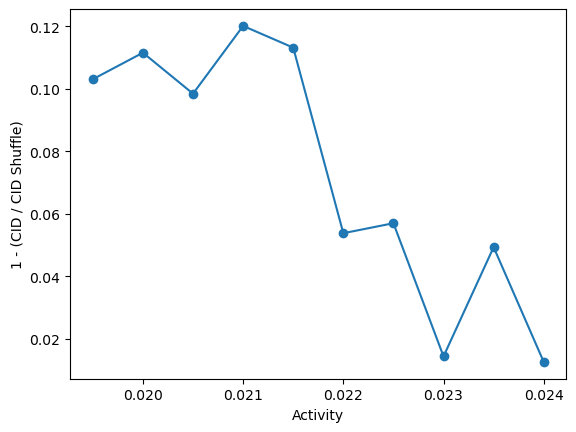

In [36]:
cid_mean = np.mean(cid_arr[:,:,0], axis=1)
cid_std = (np.std(cid_arr[:,:,0], axis=1) + np.mean(cid_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_shuffle_mean = np.mean(cid_shuffle_arr[:,:,0], axis=1)
cid_shuffle_std = (np.std(cid_shuffle_arr[:,:,0], axis=1) + np.mean(cid_shuffle_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_ratio = cid_mean / cid_shuffle_mean
cid_ratio_std = cid_ratio * np.sqrt((cid_std/cid_mean)**2 + (cid_shuffle_std/cid_shuffle_mean)**2)
cid_ratio_std = np.sqrt((cid_std)**2 + (cid_ratio)**2 * (cid_shuffle_std)**2) / cid_shuffle_mean

#plt.errorbar(act_list, cid_shuffle_mean, yerr=cid_shuffle_std, label='CID Shuffle', fmt='o-')   
#plt.errorbar(act_list, cid_mean, yerr=cid_std, label='CID', fmt='o-')
#plt.errorbar(act_list, 1-cid_ratio, yerr=cid_ratio_std, label='1 - (CID / CID Shuffle)', fmt='o-')
plt.plot(act_list, 1-cid_ratio, 'o-', label='1 - (CID / CID Shuffle)', )
plt.xlabel('Activity')
plt.ylabel('1 - (CID / CID Shuffle)')